In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_data_path = '/content/drive/My Drive/ECG-Timeseries-Classification/Dataset/train_df.pkl'
val_data_path = '/content/drive/My Drive/ECG-Timeseries-Classification/Dataset/val_df.pkl'
test_data_path = '/content/drive/My Drive/ECG-Timeseries-Classification/Dataset/test_df.pkl'

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import torch
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence, PackedSequence
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch.utils
import torch.utils.data
import scipy.signal
import sklearn.svm
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, ifft
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from typing import Tuple, List



def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Seed set for reproducibility.")


INPUT_LENGTH = 9000
BATCH_SIZE = 64
NUM_WORKERS = 0
NUM_CLASSES = 4
EPOCHS = 10
N_FFT = 256
HOP_LENGTH = 128


train_df = pd.read_pickle(train_data_path)
val_df = pd.read_pickle(val_data_path)
test_df = pd.read_pickle(test_data_path)
print(train_df.head())

Seed set for reproducibility.
                                              signal  label      rr_std
1  [-446, -541, -637, -733, -819, -858, -867, -87...      2  182.922570
3  [-1255, -1488, -1745, -2015, -2253, -2374, -23...      0  123.855300
4  [156, 189, 223, 255, 291, 330, 362, 380, 390, ...      0   32.132097
5  [-22, -27, -33, -38, -40, -39, -36, -30, -23, ...      1  145.925780
6  [291, 345, 405, 465, 510, 527, 516, 509, 507, ...      0   16.995531


In [ ]:



class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=None):
        self.df = df
        self.augmentation = augmentation
        self.target_length = (
            INPUT_LENGTH
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        signal = self.df.iloc[idx]["signal"]
        signal = np.array(signal, dtype=np.float32)
        label = int(self.df.iloc[idx]["label"])

        # keep it simple: time domain augmentation only
        signal = pad_and_augment(
            signal, self.augmentation
        )  # has padding in it. the order of augmentations should be important (wrapping changes the shape but noise and scaling before padding makes it easier to distinguish the signal length)

        signal = (signal - TRAINING_MEAN) / TRAINING_STD
        signal = torch.tensor(signal, dtype=torch.float32)

        return signal, label

class TestECGDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.target_length = INPUT_LENGTH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        signal = self.df.iloc[idx]["signal"]
        signal = np.array(signal, dtype=np.float32)

        # Only pad; no augmentation
        signal = pad_and_augment(signal, augmentation=None)

        # Normalize
        signal = (signal - TRAINING_MEAN) / TRAINING_STD
        signal = torch.tensor(signal, dtype=torch.float32)

        return signal

In [ ]:
class SimpleCNNwithoutClassifier(nn.Module):
    def __init__(self, feature_size=50):
        super(SimpleCNNwithoutClassifier, self).__init__()
        self.feature_size = feature_size

        self.convblock1 = nn.Sequential(
            nn.LazyConv2d(out_channels=16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.LazyConv2d(out_channels=16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
        )
        self.conv1 = nn.LazyConv2d(out_channels=16, kernel_size=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.convblock2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv2 = nn.Conv2d(16, 32, kernel_size=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = None
        self._fc1_initialized = False

        self.apply(he_init_weights)

    def forward(self, x):
        x = x.squeeze(1)  # Remove channel dimension if present

        x = compute_stft_batch(x)  # STFT → (batch, freq, time)
        x = torch.log1p(x)  # Apply log1p transformation

        x = x.unsqueeze(1)  # (batch, 1, freq, time)

        # First residual block
        x = self.convblock1(x) + self.conv1(x)  # Residual connection
        x = nn.ReLU()(x)
        x = self.maxpool1(x)
        # Ensure the output shape is compatible with the next layer
        if x.dim() == 3:  # If the output is 3D,
            x = x.unsqueeze(1)  # Add channel dimension


        x = self.convblock2(x) + self.conv2(x)
        x = nn.ReLU()(x)
        x = self.maxpool2(x)

        if x.dim() == 3:  # If the output is 3D,
            x = x.unsqueeze(1)  # Add channel dimension

        # Flatten
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)


        if not self._fc1_initialized:
            flattened_size = x_flat.size(1)
            self.fc1 = nn.Linear(flattened_size, self.feature_size).to(x.device)
            self._fc1_initialized = True
            print(f"Initialized fc1 with input size: {flattened_size}")

        x = self.fc1(x_flat)
        return x



class CNNwithSVM(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, feature_size=128, svm_params=None):  # hidden_size
        super().__init__()
        self.cnn_feature_extractor = SimpleCNNwithoutClassifier(
            feature_size=feature_size,
        )
        self.svm = SVC(**(svm_params or {}))
        self.is_svm_trained = False
        self._temp_classifier = None

    def forward(self, x):
        features = self.cnn_feature_extractor(x)
        if hasattr(self, "_temp_classifier") and self._temp_classifier is not None:
            return self._temp_classifier(features)
        return features

    def predict(self, x):
        if not self.is_svm_trained:
            raise ValueError("SVM not trained yet!")
        self.eval()
        with torch.no_grad():
            features = self.cnn_feature_extractor(x).cpu().numpy()
        return self.svm.predict(features)

    def _setup_temp_classifier(self, num_classes, device):
        """Add temporary classifier for CNN training"""
        feature_size = self.cnn_feature_extractor.feature_size
        self._temp_classifier = nn.Linear(feature_size, num_classes).to(device)

    def _remove_temp_classifier(self):
        """Remove temporary classifier after CNN training"""
        self._temp_classifier = None

In [ ]:
def train_model(
    model, train_loader, epochs=10, lr=0.001, batch_size_factor=4
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    is_cnn_svm = hasattr(model, "svm")
    num_classes = len(torch.unique(torch.cat([labels for _, labels in train_loader])))

    print(f"Training {'CNN+SVM' if is_cnn_svm else 'CNN'} model on {device}")

    if is_cnn_svm:
        model._setup_temp_classifier(num_classes, device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Compute class weights
    original_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_df["label"]),
        y=train_df["label"],
    )

    scaled_weights = original_weights / original_weights.max()  # normalize to max=1
    scaled_weights = 0.5 + (scaled_weights * 0.5)  # shrink range to [0.5, 1.0] for balance

    weights_tensor = torch.tensor(scaled_weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    print("Training CNN feature extractor...")
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for signals, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            signals, labels = signals.unsqueeze(1).to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100.0 * correct / total
        print(
            f"Epoch {epoch+1}: Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {acc:.2f}%"
        )

    if is_cnn_svm:
        model._remove_temp_classifier()
        _train_svm_phase(model, train_loader, device, batch_size_factor)

    return model


def _train_svm_phase(model, train_loader, device, batch_size_factor):

    print("Training SVM...")
    model.eval()
    all_features, all_labels = [], []
    batch_features, batch_labels = [], []

    # extract_features_from_loader(model, data_loader, device):
    with torch.no_grad():
        for signals, labels in tqdm(train_loader, desc="Extracting features"):
            signals = signals.unsqueeze(1).to(device)
            features = model.cnn_feature_extractor(signals)

            batch_features.append(features)
            batch_labels.append(labels)

            if len(batch_features) >= batch_size_factor:
                combined_features = torch.cat(batch_features, dim=0).cpu().numpy()
                combined_labels = torch.cat(batch_labels, dim=0).numpy()
                all_features.append(combined_features)
                all_labels.append(combined_labels)
                batch_features, batch_labels = [], []

    # Process remaining
    if batch_features:
        combined_features = torch.cat(batch_features, dim=0).cpu().numpy()
        combined_labels = torch.cat(batch_labels, dim=0).numpy()
        all_features.append(combined_features)
        all_labels.append(combined_labels)

    final_features = np.concatenate(all_features, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)

    print(f"Training SVM on {len(final_features)} samples")
    model.svm.fit(final_features, final_labels)
    model.is_svm_trained = True


def evaluate_model(model, val_loader, device):
    print("Evaluating model...")
    model.eval()
    all_predictions, all_labels = [], []
    is_cnn_svm = hasattr(model, "svm")

    with torch.no_grad():
        for signals, labels in tqdm(val_loader, desc="Evaluating"):
            signals = signals.unsqueeze(1).to(device)

            if is_cnn_svm:
                features = model.cnn_feature_extractor(signals).cpu().numpy()
                predictions = model.svm.predict(features)
            else:
                predictions = model.predict(signals)
                predictions = predictions.cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Final Validation Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_predictions))

    # get overall f1 score
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    print(f"Final Validation F1 Score: {f1:.4f}")

    # confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    # normalize heatmap colors in each row for class distribution
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=CLASS_NAMES.values(), yticklabels=CLASS_NAMES.values())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


    return f1

In [ ]:
train_df['padded_signal'] = train_df['signal'].apply(lambda x: pad_and_augment(x, augmentation=None).astype(np.float32))
print(train_df.head())

                                              signal  label      rr_std  \
1  [-446, -541, -637, -733, -819, -858, -867, -87...      2  182.922570   
3  [-1255, -1488, -1745, -2015, -2253, -2374, -23...      0  123.855300   
4  [156, 189, 223, 255, 291, 330, 362, 380, 390, ...      0   32.132097   
5  [-22, -27, -33, -38, -40, -39, -36, -30, -23, ...      1  145.925780   
6  [291, 345, 405, 465, 510, 527, 516, 509, 507, ...      0   16.995531   

                                       padded_signal  
1  [-23.0, -24.0, -34.0, -62.0, -92.0, -121.0, -1...  
3  [-1255.0, -1488.0, -1745.0, -2015.0, -2253.0, ...  
4  [156.0, 189.0, 223.0, 255.0, 291.0, 330.0, 362...  
5  [-22.0, -27.0, -33.0, -38.0, -40.0, -39.0, -36...  
6  [291.0, 345.0, 405.0, 465.0, 510.0, 527.0, 516...  


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.signal
import pandas as pd

class ECGCompressor:
    """
    Compressor for ECG signals using various approximation methods.
    """

    def piecewise_constant_approximation(self, signal, n_segments):
        """
        Approximates signal using Piecewise Constant Approximation (PCA).

        Args:
            signal: 1D numpy array of the signal.
            n_segments: Number of segments for approximation.

        Returns:
            Tuple: (approximated_signal, mae, mse)
        """
        approximated_signal = np.zeros_like(signal)
        segment_length = len(signal) // n_segments

        for i in range(n_segments):
            start = i * segment_length
            end = (i + 1) * segment_length if i < n_segments - 1 else len(signal)
            segment = signal[start:end]
            if len(segment) > 0:
                mean_value = np.mean(segment)
                approximated_signal[start:end] = mean_value

        mae = mean_absolute_error(signal, approximated_signal)
        mse = mean_squared_error(signal, approximated_signal)
        return approximated_signal, mae, mse

    def piecewise_linear_approximation(self, signal, n_segments):
        """
        Approximates signal using Piecewise Linear Approximation (PLA).

        Args:
            signal: 1D numpy array of the signal.
            n_segments: Number of segments for approximation.

        Returns:
            Tuple: (approximated_signal, mae, mse)
        """
        approximated_signal = np.zeros_like(signal)
        segment_length = len(signal) // n_segments

        for i in range(n_segments):
            start = i * segment_length
            end = (i + 1) * segment_length if i < n_segments - 1 else len(signal)
            segment = signal[start:end]

            if len(segment) > 1:
                # Fit a linear model to the segment
                x = np.arange(len(segment))
                m, c = np.polyfit(x, segment, 1)
                approximated_signal[start:end] = m * x + c

            elif len(segment) == 1:
                approximated_signal[start:end] = segment[0]


        mae = mean_absolute_error(signal, approximated_signal)
        mse = mean_squared_error(signal, approximated_signal)
        return approximated_signal, mae, mse


compressor = ECGCompressor()

compression_configs = [
    {'name': 'PCA_10%', 'method': 'piecewise_constant', 'params': {'n_segments': int(INPUT_LENGTH * 0.1)}},
    {'name': 'PCA_25%', 'method': 'piecewise_constant', 'params': {'n_segments': int(INPUT_LENGTH * 0.25)}},
    {'name': 'PCA_50%', 'method': 'piecewise_constant', 'params': {'n_segments': int(INPUT_LENGTH * 0.5)}},
]

compressed_train_datasets = {}
compressed_val_datasets = {}
compression_metrics = {}

for config in compression_configs:
    method_name = config['name']
    method_type = config['method']
    params = config['params']

    print(f"Applying {method_name} to train data...")

    compressed_signals = []
    mae_scores = []
    mse_scores = []
    labels = []

    # Iterate through the padded signals
    for idx, row in train_df.iterrows():
        signal = np.array(row['padded_signal'], dtype=np.float32)
        label = row['label']

        if method_type == 'piecewise_constant':
             # Ensure n_segments is not greater than the signal length
            params['n_segments'] = min(params['n_segments'], len(signal))
            compressed_signal, mae, mse = compressor.piecewise_constant_approximation(signal, **params)
        elif method_type == 'piecewise_linear':
            # Ensure n_segments is not greater than the signal length // 2 (for pairs of points)
            params['n_segments'] = min(params['n_segments'], len(signal) // 2 if len(signal) > 1 else 1)
            compressed_signal, mae, mse = compressor.piecewise_linear_approximation(signal, **params)
        else:
            raise ValueError(f"Unknown compression method: {method_type}")


        compressed_signals.append(compressed_signal)
        mae_scores.append(mae)
        mse_scores.append(mse)
        labels.append(label)


    compressed_train_datasets[method_name] = pd.DataFrame({
        'signal': compressed_signals,
        'label': labels
    })

    compression_metrics[method_name] = {
        'avg_mae': np.mean(mae_scores),
        'avg_mse': np.mean(mse_scores),
    }

    compressed_val_signals = []
    val_labels = []

    # Iterate through the padded signals
    for idx, row in val_df.iterrows():
        signal = np.array(row['padded_signal'], dtype=np.float32)
        label = row['label']
        if method_type == 'piecewise_constant':
             # Ensure n_segments is not greater than the signal length
            params['n_segments'] = min(params['n_segments'], len(signal))
            compressed_signal, mae, mse = compressor.piecewise_constant_approximation(signal, **params)
        elif method_type == 'piecewise_linear':
            # Ensure n_segments is not greater than the signal length // 2 (for pairs of points)
            params['n_segments'] = min(params['n_segments'], len(signal) // 2 if len(signal) > 1 else 1)
            compressed_signal, mae, mse = compressor.piecewise_linear_approximation(signal, **params)
        else:
            raise ValueError(f"Unknown compression method: {method_type}")

        compressed_signals.append(compressed_signal)
        labels.append(label)

    compressed_val_datasets[method_name] = pd.DataFrame({
        'signal': compressed_val_signals,
        'label': val_labels
    })

# Print compression metrics
print("\nCompression Metrics:")
for method, metrics in compression_metrics.items():
    print(f"  {method}: Avg MAE = {metrics['avg_mae']:.4f}, Avg MSE = {metrics['avg_mse']:.4f}")

Applying PCA_10% to train data...
Applying PCA_25% to train data...
Applying PCA_50% to train data...

Compression Metrics:
  PCA_10%: Avg MAE = 29.0789, Avg MSE = 6982.2693
  PCA_25%: Avg MAE = 12.2625, Avg MSE = 1515.7011
  PCA_50%: Avg MAE = 6.1856, Avg MSE = 327.6756


In [ ]:
class CompressedECGDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        signal = self.df.iloc[idx]["signal"]
        signal = np.array(signal, dtype=np.float32)

        # Normalize
        signal = (signal - TRAINING_MEAN) / TRAINING_STD
        signal = torch.tensor(signal, dtype=torch.float32)

        label = int(self.df.iloc[idx]["label"])


        return signal, label

Starting tests with different compression configurations...
Testing CNNwithSVM with on PCA_10% dataset
                                              signal  label
0  [-111.2, -111.2, -111.2, -111.2, -111.2, -111....      2
1  [-2016.5, -2016.5, -2016.5, -2016.5, -2016.5, ...      0
2  [297.8, 297.8, 297.8, 297.8, 297.8, 297.8, 297...      0
3  [-30.5, -30.5, -30.5, -30.5, -30.5, -30.5, -30...      1
4  [458.0, 458.0, 458.0, 458.0, 458.0, 458.0, 458...      0
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:14,  5.54it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  8.70it/s]


Epoch 1: Train Loss: 1.0042, Train Acc: 61.16%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  8.53it/s]


Epoch 2: Train Loss: 0.8478, Train Acc: 68.05%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.70it/s]


Epoch 3: Train Loss: 0.7515, Train Acc: 72.33%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  8.61it/s]


Epoch 4: Train Loss: 0.6829, Train Acc: 74.16%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  8.89it/s]


Epoch 5: Train Loss: 0.6268, Train Acc: 77.25%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  8.78it/s]


Epoch 6: Train Loss: 0.5735, Train Acc: 78.85%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  8.49it/s]


Epoch 7: Train Loss: 0.5298, Train Acc: 80.22%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.85it/s]


Epoch 8: Train Loss: 0.4472, Train Acc: 84.84%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  8.87it/s]


Epoch 9: Train Loss: 0.3977, Train Acc: 86.25%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  8.70it/s]


Epoch 10: Train Loss: 0.3646, Train Acc: 88.27%


Epoch 11/20: 100%|██████████| 83/83 [00:10<00:00,  7.60it/s]


Epoch 11: Train Loss: 0.3067, Train Acc: 91.03%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  8.75it/s]


Epoch 12: Train Loss: 0.2610, Train Acc: 93.15%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  8.72it/s]


Epoch 13: Train Loss: 0.1956, Train Acc: 95.91%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  8.72it/s]


Epoch 14: Train Loss: 0.1843, Train Acc: 96.08%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  8.66it/s]


Epoch 15: Train Loss: 0.1344, Train Acc: 98.02%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  8.77it/s]


Epoch 16: Train Loss: 0.0971, Train Acc: 99.24%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.72it/s]


Epoch 17: Train Loss: 0.1141, Train Acc: 98.50%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  8.64it/s]


Epoch 18: Train Loss: 0.0646, Train Acc: 99.70%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.66it/s]


Epoch 19: Train Loss: 0.0790, Train Acc: 99.24%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.72it/s]


Epoch 20: Train Loss: 0.0433, Train Acc: 99.87%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 54.63it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 23.40it/s]


Final Validation Accuracy: 0.6160
              precision    recall  f1-score   support

           0       0.63      0.96      0.76       544
           1       0.32      0.11      0.16        84
           2       0.55      0.14      0.22       264
           3       0.33      0.09      0.14        35

    accuracy                           0.62       927
   macro avg       0.46      0.32      0.32       927
weighted avg       0.57      0.62      0.53       927

Final Validation F1 Score: 0.5316


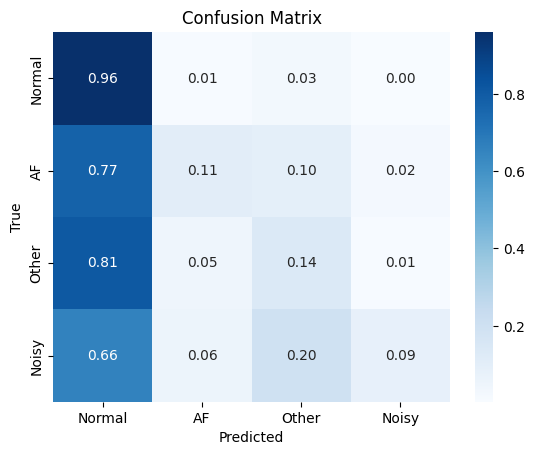

Weighted F1 of CNNwithSVM with on PCA_10%: 0.5316

Testing CNNwithSVM with on PCA_25% dataset
                                              signal  label
0  [-35.75, -35.75, -35.75, -35.75, -137.0, -137....      2
1  [-1625.75, -1625.75, -1625.75, -1625.75, -2323...      0
2  [205.75, 205.75, 205.75, 205.75, 340.75, 340.7...      0
3  [-30.0, -30.0, -30.0, -30.0, -36.25, -36.25, -...      1
4  [376.5, 376.5, 376.5, 376.5, 515.5, 515.5, 515...      0
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   0%|          | 0/83 [00:00<?, ?it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  8.59it/s]


Epoch 1: Train Loss: 0.9791, Train Acc: 63.12%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  8.71it/s]


Epoch 2: Train Loss: 0.8091, Train Acc: 70.24%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.70it/s]


Epoch 3: Train Loss: 0.7317, Train Acc: 72.28%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  8.62it/s]


Epoch 4: Train Loss: 0.6823, Train Acc: 74.79%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  8.53it/s]


Epoch 5: Train Loss: 0.6298, Train Acc: 76.75%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  8.32it/s]


Epoch 6: Train Loss: 0.5905, Train Acc: 78.60%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  8.61it/s]


Epoch 7: Train Loss: 0.5578, Train Acc: 79.28%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.67it/s]


Epoch 8: Train Loss: 0.4820, Train Acc: 82.79%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  8.56it/s]


Epoch 9: Train Loss: 0.4270, Train Acc: 85.17%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  8.60it/s]


Epoch 10: Train Loss: 0.3911, Train Acc: 86.75%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  8.72it/s]


Epoch 11: Train Loss: 0.3355, Train Acc: 89.41%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  8.65it/s]


Epoch 12: Train Loss: 0.3136, Train Acc: 90.10%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  8.63it/s]


Epoch 13: Train Loss: 0.2385, Train Acc: 93.41%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  8.66it/s]


Epoch 14: Train Loss: 0.2022, Train Acc: 94.52%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  8.60it/s]


Epoch 15: Train Loss: 0.1564, Train Acc: 97.07%


Epoch 16/20: 100%|██████████| 83/83 [00:10<00:00,  8.11it/s]


Epoch 16: Train Loss: 0.1314, Train Acc: 97.87%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.73it/s]


Epoch 17: Train Loss: 0.1162, Train Acc: 98.31%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  8.67it/s]


Epoch 18: Train Loss: 0.1066, Train Acc: 98.63%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.72it/s]


Epoch 19: Train Loss: 0.2280, Train Acc: 92.86%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.70it/s]


Epoch 20: Train Loss: 0.0804, Train Acc: 99.35%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 57.38it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 36.12it/s]


Final Validation Accuracy: 0.5987
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       544
           1       0.64      0.08      0.15        84
           2       0.44      0.56      0.49       264
           3       0.31      0.49      0.38        35

    accuracy                           0.60       927
   macro avg       0.53      0.46      0.43       927
weighted avg       0.62      0.60      0.59       927

Final Validation F1 Score: 0.5885


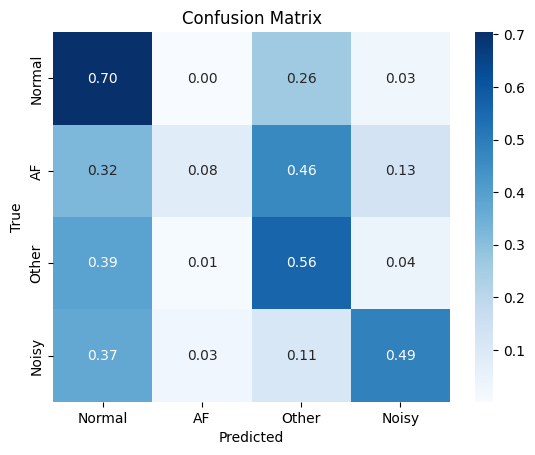

Weighted F1 of CNNwithSVM with on PCA_25%: 0.5885

Testing CNNwithSVM with on PCA_50% dataset
                                              signal  label
0  [-23.5, -23.5, -48.0, -48.0, -106.5, -106.5, -...      2
1  [-1371.5, -1371.5, -1880.0, -1880.0, -2313.5, ...      0
2  [172.5, 172.5, 239.0, 239.0, 310.5, 310.5, 371...      0
3  [-24.5, -24.5, -35.5, -35.5, -39.5, -39.5, -33...      1
4  [318.0, 318.0, 435.0, 435.0, 518.5, 518.5, 512...      0
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:10,  7.51it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  8.59it/s]


Epoch 1: Train Loss: 1.0307, Train Acc: 59.65%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  8.68it/s]


Epoch 2: Train Loss: 0.8593, Train Acc: 67.69%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.58it/s]


Epoch 3: Train Loss: 0.7680, Train Acc: 71.53%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  8.60it/s]


Epoch 4: Train Loss: 0.7059, Train Acc: 73.31%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  8.60it/s]


Epoch 5: Train Loss: 0.6656, Train Acc: 75.89%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  8.62it/s]


Epoch 6: Train Loss: 0.6198, Train Acc: 77.44%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  8.78it/s]


Epoch 7: Train Loss: 0.5814, Train Acc: 78.22%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.66it/s]


Epoch 8: Train Loss: 0.5146, Train Acc: 81.23%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  8.60it/s]


Epoch 9: Train Loss: 0.4763, Train Acc: 82.98%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  8.65it/s]


Epoch 10: Train Loss: 0.4642, Train Acc: 83.49%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  8.63it/s]


Epoch 11: Train Loss: 0.3861, Train Acc: 86.96%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  8.77it/s]


Epoch 12: Train Loss: 0.3432, Train Acc: 89.30%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  8.64it/s]


Epoch 13: Train Loss: 0.3030, Train Acc: 90.71%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  8.73it/s]


Epoch 14: Train Loss: 0.2794, Train Acc: 90.94%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  8.51it/s]


Epoch 15: Train Loss: 0.2090, Train Acc: 95.01%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  8.74it/s]


Epoch 16: Train Loss: 0.1847, Train Acc: 95.85%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.73it/s]


Epoch 17: Train Loss: 0.1956, Train Acc: 95.05%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  8.61it/s]


Epoch 18: Train Loss: 0.1291, Train Acc: 98.06%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.64it/s]


Epoch 19: Train Loss: 0.1445, Train Acc: 96.95%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.63it/s]


Epoch 20: Train Loss: 0.0860, Train Acc: 99.12%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 44.66it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 19.51it/s]


Final Validation Accuracy: 0.6095
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       544
           1       0.53      0.49      0.51        84
           2       0.43      0.50      0.46       264
           3       0.38      0.66      0.48        35

    accuracy                           0.61       927
   macro avg       0.53      0.58      0.54       927
weighted avg       0.63      0.61      0.62       927

Final Validation F1 Score: 0.6182


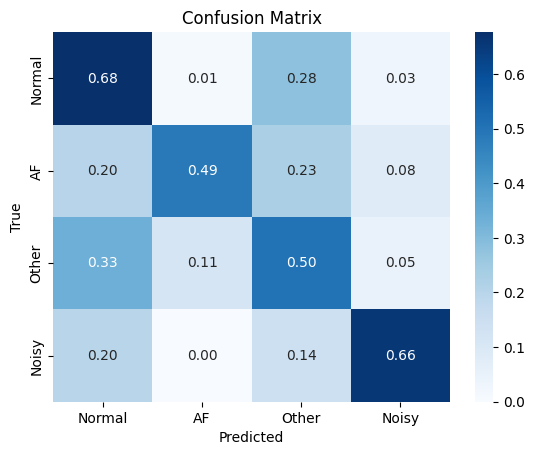

Weighted F1 of CNNwithSVM with on PCA_50%: 0.6182

All compression tests completed.


In [ ]:
test_space_compression = {
    "model": [CNNwithSVM],
    "dataset": {
        **compressed_train_datasets,
    },
}

compression_results = []
print("Starting tests with different compression configurations...")

device = "cuda" if torch.cuda.is_available() else "cpu"

for dataset_name, dataset_df in test_space_compression["dataset"].items():
    print(f"Testing CNNwithSVM with on {dataset_name} dataset")
    print(dataset_df.head())
    train_set = CompressedECGDataset(dataset_df)
    train_loader = DataLoader(train_set,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              generator=torch.Generator().manual_seed(42))

    val_loader = DataLoader(val_set,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=False)

    model = CNNwithSVM(
        feature_size=50,
        num_classes=NUM_CLASSES
    )
    model.to(device)
    trained_model = train_model(model, train_loader, epochs=20, lr=0.001, batch_size_factor=4)
    f1 = evaluate_model(trained_model, val_loader, device)
    print(f"Weighted F1 of CNNwithSVM with on {dataset_name}: {f1:.4f}\n")
    compression_results.append({
        "dataset": dataset_name,
        "f1": f1,
    })
    del trained_model
    torch.cuda.empty_cache()
    del train_set, val_set, train_loader, val_loader

print("All compression tests completed.")